# Data Analysis

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_csv('../data/raw/energy_dataset.csv', parse_dates=['time'])
data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

# Hydro Water Reservoir Energy Generation

In [4]:
hydro_data = data.filter(regex='hydro|time')

In [5]:
reservoir_gen = hydro_data.filter(['time', 'generation hydro water reservoir']) \
                          .rename(columns={'generation hydro water reservoir':'generation'}) \
                          .set_index('time') \
                          .asfreq('H') \
                          .interpolate() \
                          .sort_index()

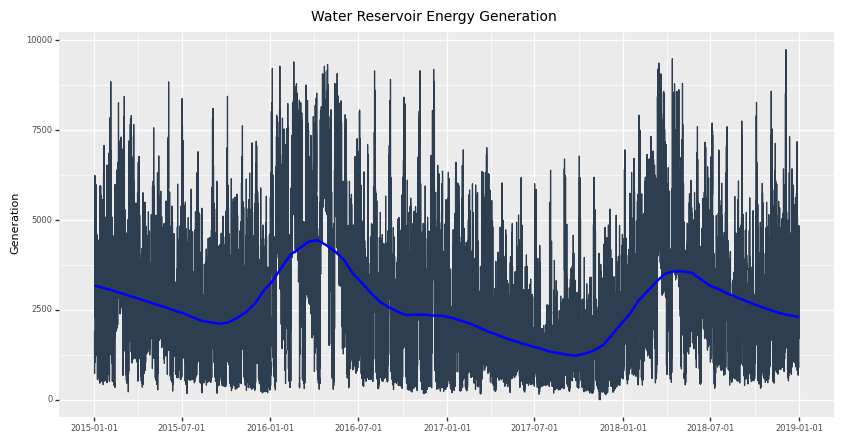

<ggplot: (8757698128467)>

In [6]:
ggplot(data=reservoir_gen.reset_index(), mapping=aes(x="time", y="generation")) + \
geom_line(color = "#2C3E50") + \
    geom_smooth(method = "loess",
                se = False,
                color = "blue",
                span = 0.3) + \
    labs(
        title = "Water Reservoir Energy Generation",
        x = "",
        y = "Generation"
    ) + \
    theme(axis_text_y = element_text(size = 6),
          axis_text_x = element_text(size = 6),
          plot_title  = element_text(size = 10),
          axis_title_y= element_text(size=8),
          figure_size=(10,5)
          )

In [7]:
reservoir_gen.index.is_unique

True

In [8]:
reservoir_gen.isna().sum()

generation    0
dtype: int64

In [9]:
# Time series decomposition analysis
res = STL(reservoir_gen.generation).fit()
seasonal, trend, resid = res.seasonal, res.trend, res.resid


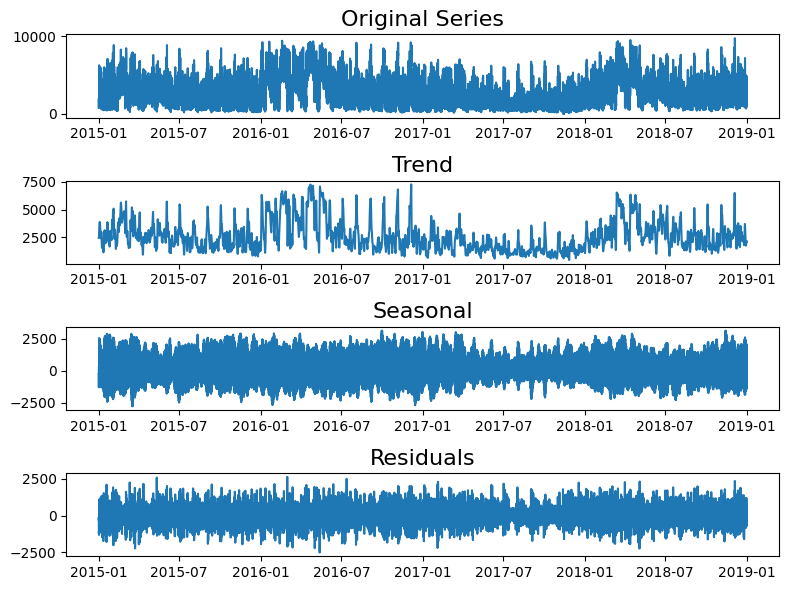

In [10]:
plt.figure(figsize=(8,6))

plt.subplot(4, 1, 1)
plt.plot(reservoir_gen.generation)
plt.title('Original Series', fontsize = 16)

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend', fontsize = 16)

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize = 16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residuals', fontsize = 16)

plt.tight_layout()

In [11]:
# Extract trend with LOWESS
y = reservoir_gen.generation
x = np.arange(0, len(y))

res = lowess(endog = y, exog = x, frac = 0.1, it = 3)
reservoir_gen['lowess'] = res[:, 1]
reservoir_gen.head()

,generation,lowess
time,,
2015-01-01 00:00:00+01:00,1899.0,2717.290819
2015-01-01 01:00:00+01:00,1658.0,2717.486236
2015-01-01 02:00:00+01:00,1371.0,2717.681536
2015-01-01 03:00:00+01:00,779.0,2717.876718
2015-01-01 04:00:00+01:00,720.0,2718.071781


Text(0.5, 0, 'Time')

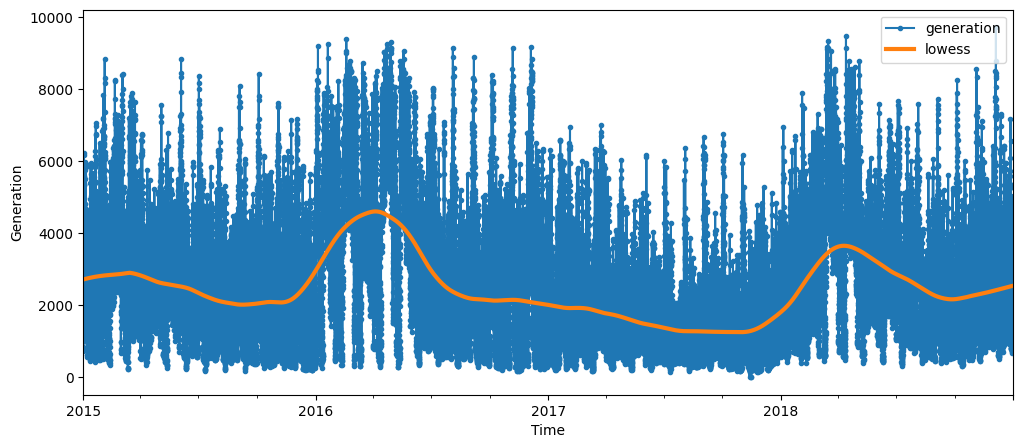

In [12]:
fig, ax = plt.subplots(figsize = [12,5])
reservoir_gen.plot(y = 'generation', marker = '.', ax = ax)
reservoir_gen.plot(y = 'lowess', ax = ax, linewidth = 3)
ax.set_ylabel('Generation')
ax.set_xlabel('Time')

Text(0.5, 1.0, 'Reservoir Power Generation by Month')

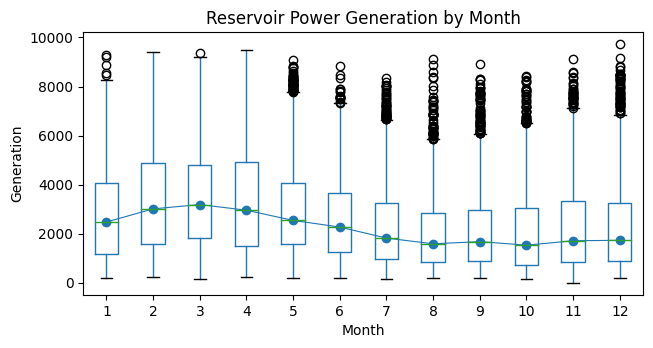

In [13]:
# Seasonal analysis
fig, ax = plt.subplots(figsize = [7, 3.5])
reservoir_gen['month'] = reservoir_gen.index.month
reservoir_gen.boxplot(column='generation', by = 'month', ax = ax)
reservoir_gen.groupby('month')['generation'].median().plot(style='o-', linewidth = 0.8, ax = ax)
ax.set_ylabel('Generation')
ax.set_xlabel('Month')
fig.suptitle('')
ax.set_title('Reservoir Power Generation by Month')

Text(0.5, 1.0, 'Reservoir Power Generation by Day of Week')

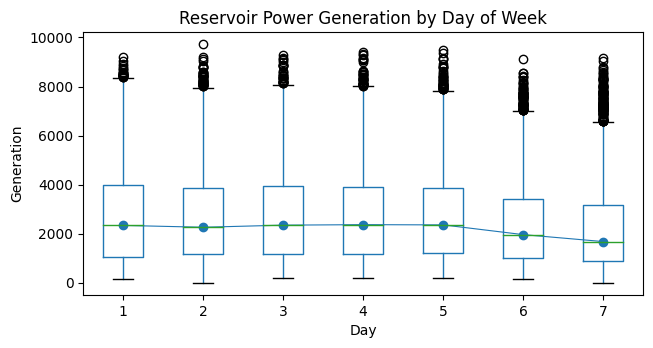

In [14]:
fig, ax = plt.subplots(figsize = [7, 3.5])
reservoir_gen['day_of_week'] = reservoir_gen.index.day_of_week + 1
reservoir_gen.boxplot(column='generation', by = 'day_of_week', ax = ax)
reservoir_gen.groupby('day_of_week')['generation'].median().plot(style='o-', linewidth = 0.8, ax = ax)
ax.set_ylabel('Generation')
ax.set_xlabel('Day')
fig.suptitle('')
ax.set_title('Reservoir Power Generation by Day of Week')

Text(0.5, 1.0, 'Reservoir Power Generation by Hour')

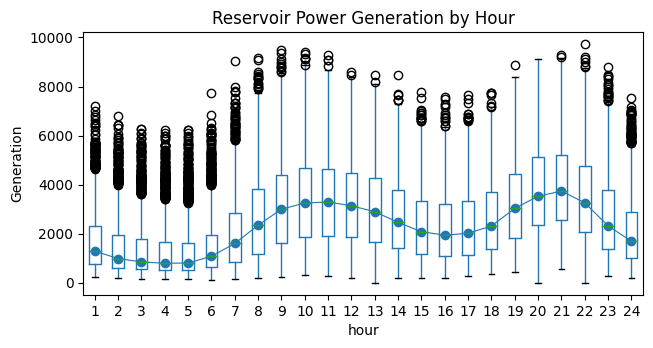

In [15]:
fig, ax = plt.subplots(figsize = [7, 3.5])
reservoir_gen['hour'] = reservoir_gen.index.hour + 1
reservoir_gen.boxplot(column='generation', by = 'hour', ax = ax)
reservoir_gen.groupby('hour')['generation'].median().plot(style='o-', linewidth = 0.8, ax = ax)
ax.set_ylabel('Generation')
ax.set_xlabel('hour')
fig.suptitle('')
ax.set_title('Reservoir Power Generation by Hour')

Text(0.5, 0, 'Lag')

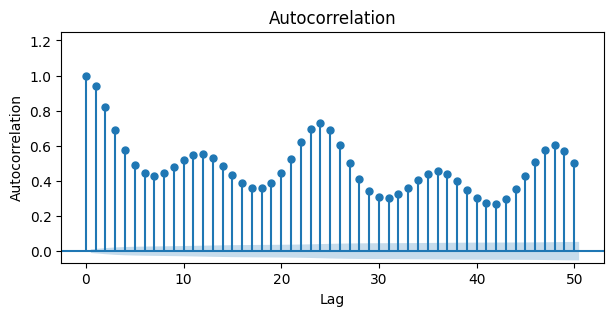

In [16]:
# Autocorrelation and partial autocorrelation
fig, ax = plt.subplots(figsize=[7, 3])
plot_acf(
    x = reservoir_gen.generation,
    lags = 50,
    ax = ax,
    alpha = 0.05,
    auto_ylims = True
)
ax.set_title('Autocorrelation')
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag')

Text(0.5, 0, 'Lag')

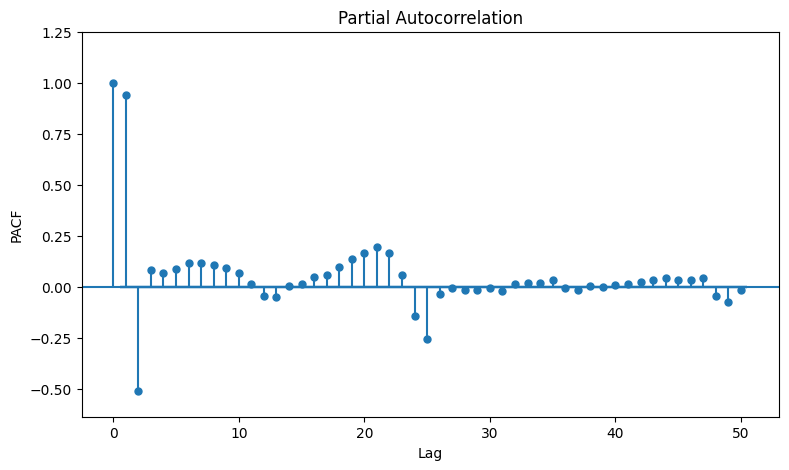

In [17]:
fig, ax = plt.subplots(figsize=[9, 5])
plot_pacf(
    x = reservoir_gen.generation,
    lags = 50,
    ax = ax,
    alpha = 0.05,
    auto_ylims = True,
    method = 'ywm'
)
ax.set_title('Partial Autocorrelation')
ax.set_ylabel('PACF')
ax.set_xlabel('Lag')

In [18]:
# Test for stationarity
from statsmodels.tsa.stattools import adfuller
X = reservoir_gen.generation
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items(): print('\t%s: %.3f' % (key, value))
print('If p> 0.05 La serie no es estacionaria')

ADF Statistic: -11.978126
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
If p> 0.05 La serie no es estacionaria
